In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.fftpack import fft,ifft
import pandas as pd
from scipy.optimize import minimize

In [2]:
# N=20取log bin的函数

def databin_20(lst):
    result = [[]]    
    length = len(lst)
    n = 0
    for i in range(length):
        result[-1].append(math.log(lst[i],10))
        n = n+1
        if n ==20:
            n = 0
            result.append([])
    result.pop()
    output=[]
    for j in range(len(result)):
        output.append((np.median(result[j]))) 
    return output

def databin_20_std(lst):
    result = [[]]
    length = len(lst)
    n = 0
    for i in range(length):
        result[-1].append(math.log(lst[i],10))
        n = n+1
        if n == 20:
            n = 0
            result.append([]) 
    result.pop()
    output=[]
    for j in range(len(result)):
        output.append(np.std(result[j]))
    return output

In [3]:
# 参考 08 Arevalo 取log bin的函数

def databin_are(lst,f):
    result = [[]]
    f_length = len(f)
    f_i = f[0]
    for i in range(f_length):
        if f[i]<=1.3*f_i:
            result[-1].append(math.log(lst[i],10))
        else:
            if len(result[-1])<=2:
                result[-1].append(math.log(lst[i],10))
            else:
                result.append([])
                result[-1].append(math.log(lst[i],10))
                f_i = f[i]
    result.pop()
    output=[]
    for j in range(len(result)):
        output.append(np.mean(result[j]))
    return output        
            

def databin_are_std(lst,f):
    result = [[]]
    f_length = len(f)
    f_i = f[0]
    for i in range(f_length):
        if f[i]<=1.3*f_i:
            result[-1].append(math.log(lst[i],10))
        else:
            if len(result[-1])<=2:
                result[-1].append(math.log(lst[i],10))
            else:
                result.append([])
                result[-1].append(math.log(lst[i],10))
                f_i = f[i]
    result.pop()
    output=[]
    for j in range(len(result)):
        output.append(np.std(result[j]))
    return output

nf = 1104.0
df = 9.057971014492753e-06
length of f = 1103
length of per = 1103
mean_x = 26.78562737318842


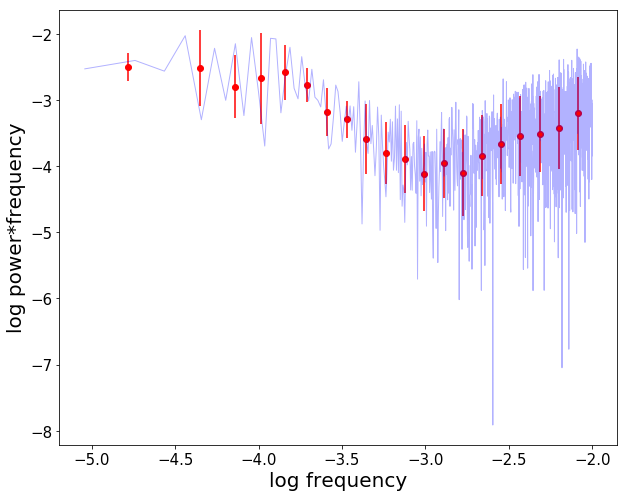

In [5]:
data06 = pd.read_csv("0.3_10_tb50.csv")
'''data06['RATE'] = data06['RATE'].fillna(data092['RATE'].mean())   # 平均值插值'''
data06['RATE'] = data06['RATE'].interpolate()


dt=50
counts_data = data06['RATE']
N = len(counts_data)
pnum = np.arange(len(counts_data))
t = [i*dt for i in pnum]


nf = N/2
df = 1/(dt*N)
F_a = np.arange(nf+1)
F = [i*df for i in F_a]
F1 = F[1:int(nf)]
mean_x = np.mean(counts_data)
dft = fft(counts_data-mean_x)
dft1 = dft[1:int(nf)]
per_data = (abs(dft1)**2)*2*dt/((mean_x**2)*N)
p_times_f_data = np.multiply(np.array(F1),np.array(per_data))

print('nf =', nf)
print('df =', df)
print('length of f =', len(F1))
print('length of per =', len(per_data))
print('mean_x =', mean_x)

F1_log_06 = [math.log(i,10) for i in F1]
ptf_data_log_00 = [math.log(i,10) for i in p_times_f_data]

# 数据分bin
F1_binned_06 = databin_are(F1,F1)
per_data_binned_06 = databin_are(per_data,F1)
per_data_b_std_06 = databin_are_std(per_data,F1)
p_times_f_data_b_06 = np.array(F1_binned_06)+np.array(per_data_binned_06)

'''
#减掉泊松噪声分bin
per_nobs = [i-2/mean_x for i in per_data]
F1_binned_06 = databin_20(F1)
per_data_binned_06 = databin_20(per_nobs)
per_data_b_std_06 = databin_20_std(per_nobs)
p_times_f_data_b_06 = np.array(F1_binned_06)+np.array(per_data_binned_06)
'''


plt.figure(figsize=(10,8))
plt.plot(F1_log_06, ptf_data_log_00, color="b", alpha=0.3, linewidth=1)
plt.scatter(F1_binned_06, p_times_f_data_b_06, color="r", linewidth=1) 
plt.errorbar(F1_binned_06, p_times_f_data_b_06, yerr=per_data_b_std_06, fmt='.r')
plt.xlabel("log frequency",fontsize=20)
plt.ylabel("log power*frequency",fontsize=20)
plt.tick_params(labelsize=15)
plt.show()

perlist_06 = {'f':F1,'per':per_data}
test = pd.DataFrame(perlist_06,columns = ['f','per'])
test.to_csv('perlist06.csv')

perb=[10**i for i in per_data_binned_06]
fb=[10**i for i in F1_binned_06]
stdb=[10**i for i in per_data_b_std_06]
perlistbinned_06 = {'f':fb,'per':perb,'std':stdb}
test = pd.DataFrame(perlistbinned_06,columns = ['f','per','std'])
test.to_csv('perlistbinned06.csv')

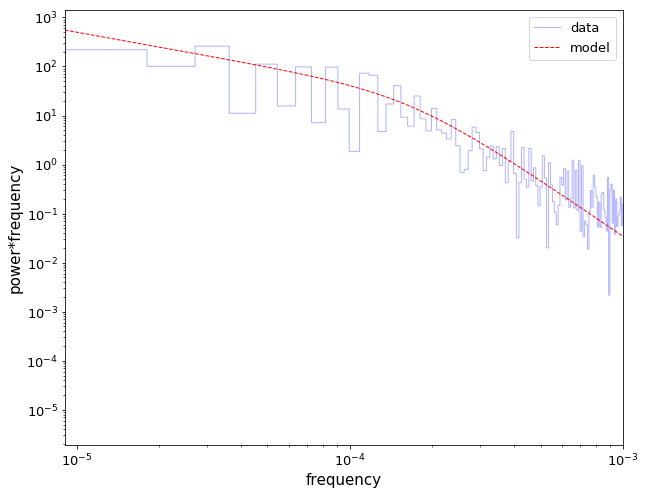

In [5]:
parameter = [0.005, 1.7E-4, 3.8]
model=[]
A=parameter[0]
f_b=parameter[1]
alpha_H=parameter[2]
alpha_L=1.0
f_length = len(F1)
for i in range(f_length):
    model.append(((F1[i]**(-alpha_L))/(1+(F1[i]/f_b)**(alpha_H-alpha_L)))*A)
model_times_f = np.multiply(np.array(F1),np.array(model))
    

    

plt.figure(figsize=(10,8))
plt.loglog()
plt.step(F1, per_data, color="b", alpha=0.3, linewidth=1,label="data")
plt.plot(F1, model, color="r",ls="--", linewidth=1,label="model")
plt.xlabel("frequency",fontsize=15)
plt.ylabel("power*frequency",fontsize=15)
plt.tick_params(labelsize=13)
plt.legend(fontsize=13)
plt.xlim(F1[0],10**-3)
plt.show()

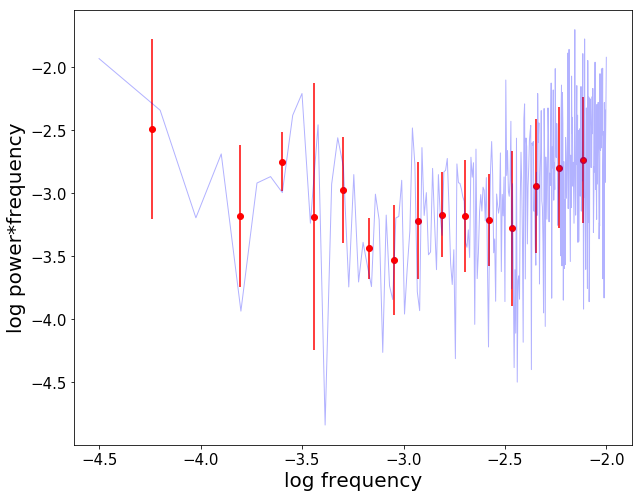

In [6]:
data00 = pd.read_csv("03_10_tb50(00).csv")  
data00['RATE'] = data00['RATE'].interpolate()


dt=50
counts_data = data00['RATE']
N=len(counts_data)
pnum = np.arange(len(counts_data))
t = [i*dt for i in pnum]


nf = N/2
df = 1/(dt*N)
F_a = np.arange(1,nf+1)
F = [i*df for i in F_a]
F1 = F[0:int(nf)]
mean_x = np.mean(counts_data)
dft = fft(counts_data)
dft1= dft[1:int(nf)+1]
per_data = (abs(dft1)**2)*2*dt/((mean_x**2)*N)
p_times_f_data = np.multiply(np.array(F1),np.array(per_data))

F1_log_00 = [math.log(i,10) for i in F1]
ptf_data_log_00 = [math.log(i,10) for i in p_times_f_data]

# 数据分bin
F1_binned_00 = databin_are(F1,F1)
per_data_binned_00 = databin_are(per_data,F1)
per_data_b_std_00 = databin_are_std(per_data,F1)
p_times_f_data_b_00 = np.array(F1_binned_00)+np.array(per_data_binned_00)



plt.figure(figsize=(10,8))
plt.plot(F1_log_00, ptf_data_log_00, color="b", alpha=0.3, linewidth=1)
plt.scatter(F1_binned_00, p_times_f_data_b_00, color="r", linewidth=1) 
plt.errorbar(F1_binned_00, p_times_f_data_b_00, yerr=per_data_b_std_00, fmt='.r')
plt.xlabel("log frequency",fontsize=20)
plt.ylabel("log power*frequency",fontsize=20)
plt.tick_params(labelsize=15)
plt.show()

perlist_00 = {'f':F1,'per':per_data}
test = pd.DataFrame(perlist_00,columns = ['f','per'])
test.to_csv('perlist00.csv')

perb=[10**i for i in per_data_binned_00]
fb=[10**i for i in F1_binned_00]
stdb=[10**i for i in per_data_b_std_00]
perlistbinned_00 = {'f':fb,'per':perb,'std':stdb}
test = pd.DataFrame(perlistbinned_00,columns = ['f','per','std'])
test.to_csv('perlistbinned00.csv')

[0.02973235109135774, 0.5937641111294195, 0.32301261224330313, 0.7240908759630801, 0.29518555039458366, 0.2776670334812964, 0.30689608025167, 0.46595430410069033, 0.4130225966481807, 0.5703269500363728, 0.748159226380657, 0.46221253945387697, 0.4785799587848321, 0.6359039894754327, 0.6132613008103793, 0.4902061647971224, 0.5940162131955506, 0.6229004365784919, 0.6319608029628385]


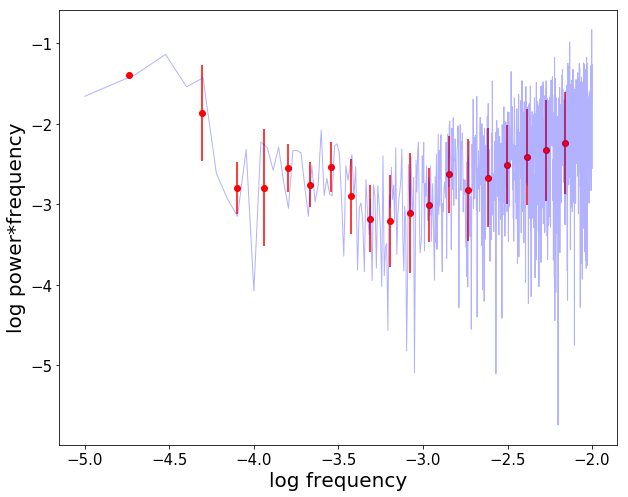

In [7]:
data091 = pd.read_csv("03_10_tb50(091).csv")  
data091['RATE'] = data091['RATE'].interpolate()


dt=50
counts_data = data091['RATE']
N=len(counts_data)
pnum = np.arange(len(counts_data))
t = [i*dt for i in pnum]


nf = N/2
df = 1/(dt*N)
F_a = np.arange(1,nf+1)
F = [i*df for i in F_a]
F1 = F[0:int(nf)]
mean_x = np.mean(counts_data)
dft = fft(counts_data)
dft1= dft[1:int(nf)+1]
per_data = (abs(dft1)**2)*2*dt/((mean_x**2)*N)
p_times_f_data = np.multiply(np.array(F1),np.array(per_data))

F1_log_091 = [math.log(i,10) for i in F1]
ptf_data_log_091 = [math.log(i,10) for i in p_times_f_data]

# 数据分bin
F1_binned_091 = databin_are(F1,F1)
per_data_binned_091 = databin_are(per_data,F1)
per_data_b_std_091 = databin_are_std(per_data,F1)
p_times_f_data_b_091 = np.array(F1_binned_091)+np.array(per_data_binned_091)

print (per_data_b_std_091)


plt.figure(figsize=(10,8))
plt.plot(F1_log_091, ptf_data_log_091, color="b", alpha=0.3, linewidth=1)
plt.scatter(F1_binned_091, p_times_f_data_b_091, color="r", linewidth=1) 
plt.errorbar(F1_binned_091, p_times_f_data_b_091, yerr=per_data_b_std_091, fmt='.r')
plt.xlabel("log frequency",fontsize=20)
plt.ylabel("log power*frequency",fontsize=20)
plt.tick_params(labelsize=15)
plt.show()

perlist_091 = {'f':F1,'per':per_data}
test = pd.DataFrame(perlist_091,columns = ['f','per'])
test.to_csv('perlist091.csv')

perb=[10**i for i in per_data_binned_091]
fb=[10**i for i in F1_binned_091]
stdb=[10**i for i in per_data_b_std_091]
perlistbinned_091 = {'f':fb,'per':perb,'std':stdb}
test = pd.DataFrame(perlistbinned_091,columns = ['f','per','std'])
test.to_csv('perlistbinned091.csv')

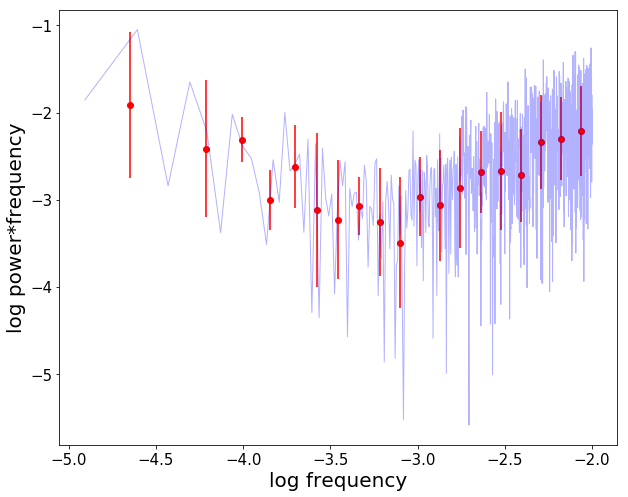

In [8]:
data092 = pd.read_csv("03_10_tb50(092).csv")  
data092['RATE'] = data092['RATE'].interpolate()


dt=50
counts_data = data092['RATE']
N=len(counts_data)
pnum = np.arange(len(counts_data))
t = [i*dt for i in pnum]


nf = N/2
df = 1/(dt*N)
F_a = np.arange(1,nf+1)
F = [i*df for i in F_a]
F1 = F[0:int(nf)]
mean_x = np.mean(counts_data)
dft = fft(counts_data)
dft1= dft[1:int(nf)+1]
per_data = (abs(dft1)**2)*2*dt/((mean_x**2)*N)
p_times_f_data = np.multiply(np.array(F1),np.array(per_data))

F1_log_092 = [math.log(i,10) for i in F1]
ptf_data_log_092 = [math.log(i,10) for i in p_times_f_data]

# 数据分bin
F1_binned_092 = databin_are(F1,F1)
per_data_binned_092 = databin_are(per_data,F1)
per_data_b_std_092 = databin_are_std(per_data,F1)
p_times_f_data_b_092 = np.array(F1_binned_092)+np.array(per_data_binned_092)



plt.figure(figsize=(10,8))
plt.plot(F1_log_092, ptf_data_log_092, color="b", alpha=0.3, linewidth=1)
plt.scatter(F1_binned_092, p_times_f_data_b_092, color="r", linewidth=1) 
plt.errorbar(F1_binned_092, p_times_f_data_b_092, yerr=per_data_b_std_092, fmt='.r')
plt.xlabel("log frequency",fontsize=20)
plt.ylabel("log power*frequency",fontsize=20)
plt.tick_params(labelsize=15)
plt.show()

perlist_092 = {'f':F1,'per':per_data}
test = pd.DataFrame(perlist_092,columns = ['f','per'])
test.to_csv('perlist092.csv')

perb=[10**i for i in per_data_binned_092]
fb=[10**i for i in F1_binned_092]
stdb=[10**i for i in per_data_b_std_092]
perlistbinned_092 = {'f':fb,'per':perb,'std':stdb}
test = pd.DataFrame(perlistbinned_092,columns = ['f','per','std'])
test.to_csv('perlistbinned092.csv')

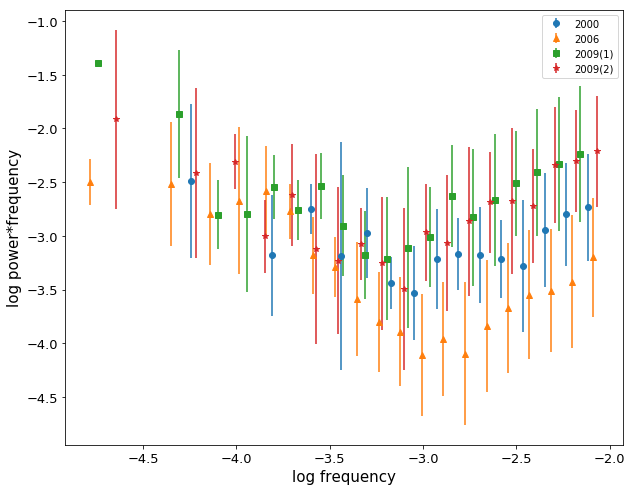

In [9]:
plt.figure(figsize=(10,8))
plt.errorbar(F1_binned_00, p_times_f_data_b_00, yerr=per_data_b_std_00, fmt='o', label='2000')
plt.errorbar(F1_binned_06, p_times_f_data_b_06, yerr=per_data_b_std_06, fmt='^', label='2006')
plt.errorbar(F1_binned_091, p_times_f_data_b_091, yerr=per_data_b_std_091, fmt='s',label='2009(1)')
plt.errorbar(F1_binned_092, p_times_f_data_b_092, yerr=per_data_b_std_092, fmt='*',label='2009(2)')
plt.xlabel("log frequency",fontsize=15)
plt.ylabel("log power*frequency",fontsize=15)
plt.tick_params(labelsize=13)
plt.legend()
plt.show()

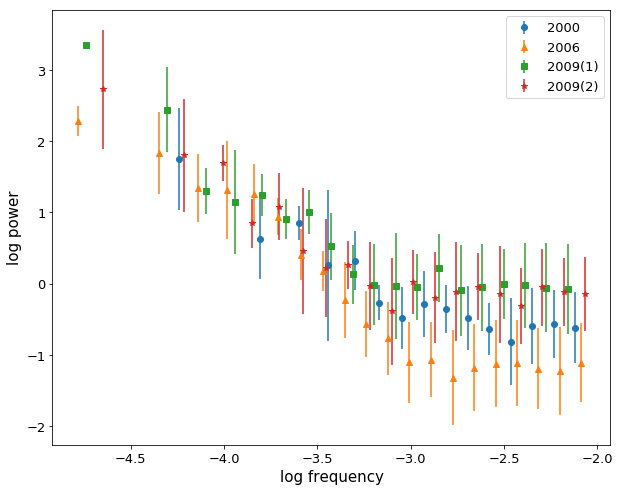

In [10]:
plt.figure(figsize=(10,8))
plt.errorbar(F1_binned_00, per_data_binned_00, yerr=per_data_b_std_00, fmt='o', label='2000')
plt.errorbar(F1_binned_06, per_data_binned_06, yerr=per_data_b_std_06, fmt='^', label='2006')
plt.errorbar(F1_binned_091, per_data_binned_091, yerr=per_data_b_std_091, fmt='s',label='2009(1)')
plt.errorbar(F1_binned_092, per_data_binned_092, yerr=per_data_b_std_092, fmt='*',label='2009(2)')
plt.xlabel("log frequency",fontsize=15)
plt.ylabel("log power",fontsize=15)
plt.tick_params(labelsize=13)
plt.legend(fontsize=13)
plt.show()

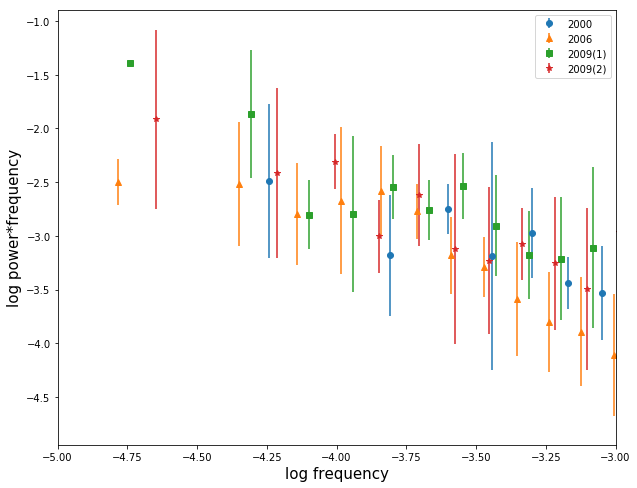

In [11]:
plt.figure(figsize=(10,8))
plt.errorbar(F1_binned_00, p_times_f_data_b_00, yerr=per_data_b_std_00, fmt='o', label='2000')
plt.errorbar(F1_binned_06, p_times_f_data_b_06, yerr=per_data_b_std_06, fmt='^', label='2006')
plt.errorbar(F1_binned_091, p_times_f_data_b_091, yerr=per_data_b_std_091, fmt='s',label='2009(1)')
plt.errorbar(F1_binned_092, p_times_f_data_b_092, yerr=per_data_b_std_092, fmt='*',label='2009(2)')
plt.xlabel("log frequency",fontsize=15)
plt.ylabel("log power*frequency",fontsize=15)
plt.xlim(-5.0,-3.0)
plt.legend()
plt.show()

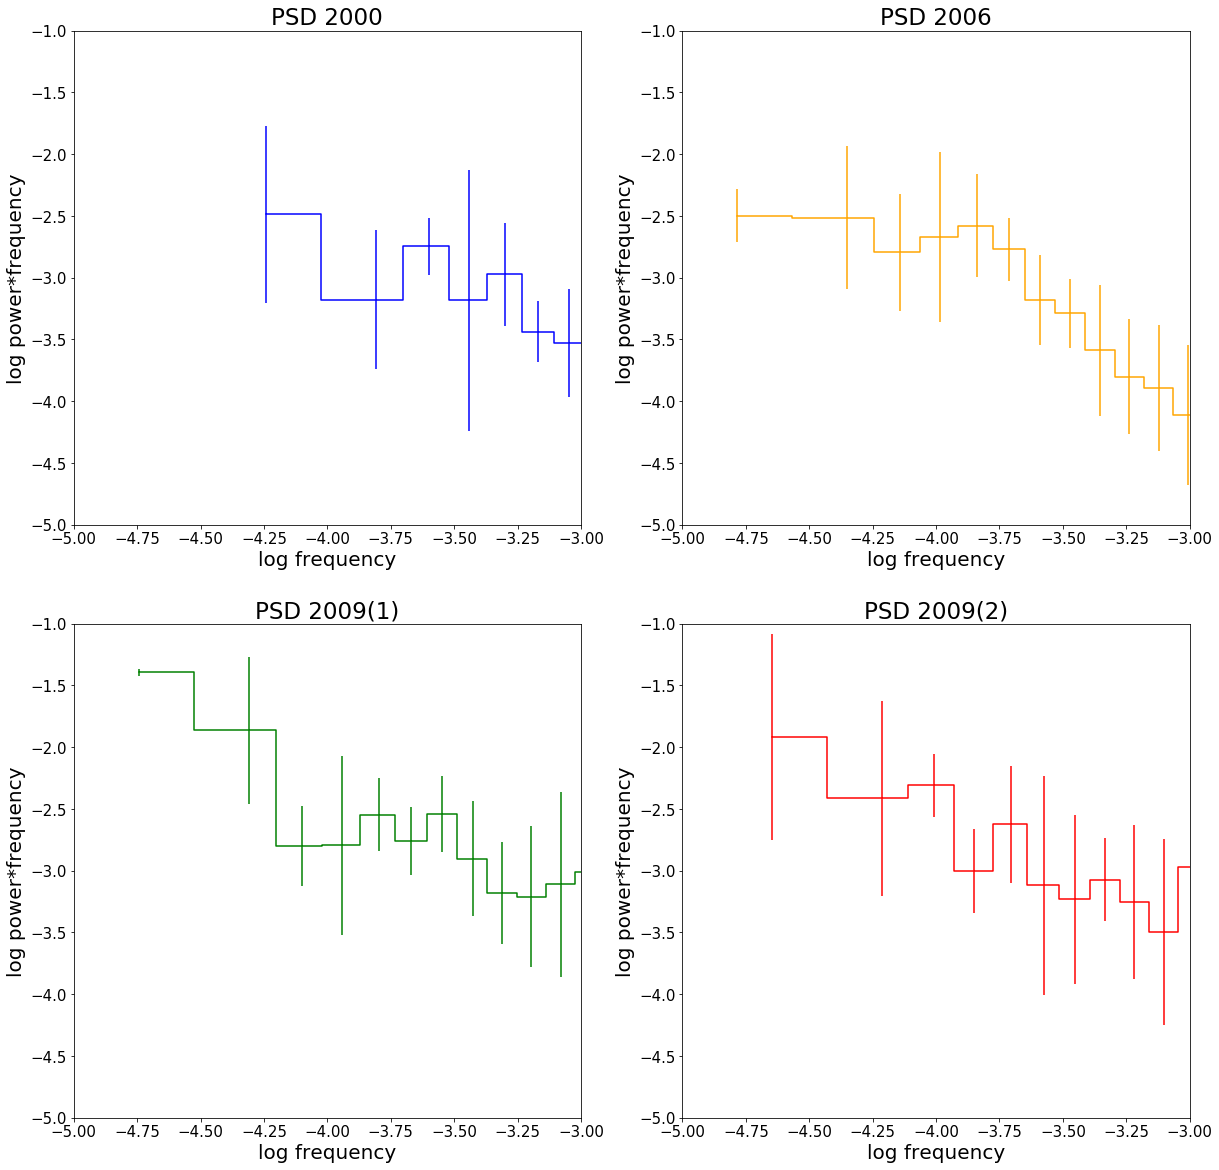

In [12]:
fig= plt.figure(figsize=(20,20))
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)

ax1.step(F1_binned_00, p_times_f_data_b_00, where='mid',color="b")
ax2.step(F1_binned_06, p_times_f_data_b_06, where='mid',color="orange")
ax3.step(F1_binned_091, p_times_f_data_b_091, where='mid', color="g")
ax4.step(F1_binned_092, p_times_f_data_b_092, where='mid', color="r")

ax1.errorbar(F1_binned_00, p_times_f_data_b_00, yerr=per_data_b_std_00, fmt=',',color="b", label='2000')
ax2.errorbar(F1_binned_06, p_times_f_data_b_06, yerr=per_data_b_std_06, fmt=',',color="orange", label='2006')
ax3.errorbar(F1_binned_091, p_times_f_data_b_091, yerr=per_data_b_std_091, fmt=',',color="g",label='2009(1)')
ax4.errorbar(F1_binned_092, p_times_f_data_b_092, yerr=per_data_b_std_092, fmt=',',color="r",label='2009(2)')


ax1.set_xlabel("log frequency",fontsize=20)
ax1.set_ylabel("log power*frequency",fontsize=20)
ax1.set_xlim(-5.0,-3.0)
ax1.set_ylim(-5,-1)
ax1.tick_params(labelsize=15)
ax1.set_title("PSD 2000",fontsize=23)
ax2.set_xlabel("log frequency",fontsize=20)
ax2.set_ylabel("log power*frequency",fontsize=20)
ax2.set_xlim(-5.0,-3.0)
ax2.set_ylim(-5,-1)
ax2.tick_params(labelsize=15)
ax2.set_title("PSD 2006",fontsize=23)
ax3.set_xlabel("log frequency",fontsize=20)
ax3.set_ylabel("log power*frequency",fontsize=20)
ax3.set_xlim(-5.0,-3.0)
ax3.set_ylim(-5,-1)
ax3.tick_params(labelsize=15)
ax3.set_title("PSD 2009(1)",fontsize=23)
ax4.set_xlabel("log frequency",fontsize=20)
ax4.set_ylabel("log power*frequency",fontsize=20)
ax4.set_xlim(-5.0,-3.0)
ax4.set_ylim(-5,-1)
ax4.tick_params(labelsize=15)
ax4.set_title("PSD 2009(2)",fontsize=23)
plt.show()

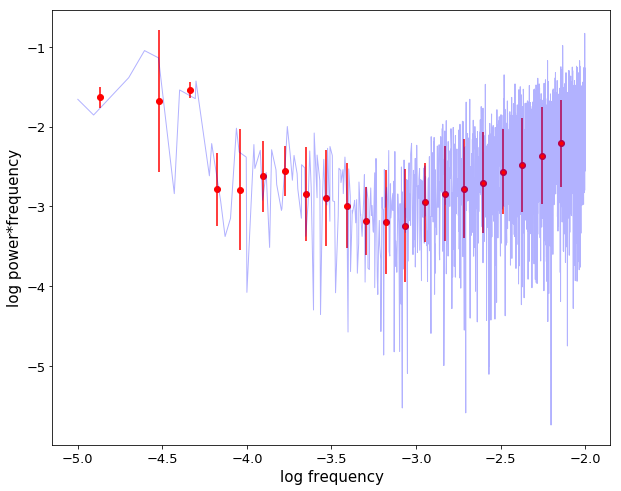

In [13]:
data09 = pd.read_csv("perlist09.csv")  

F1 = data09['f']
per_data = data09['per']
p_times_f_data = np.multiply(np.array(F1),np.array(per_data))
F1_log_09 = [math.log(i,10) for i in F1]
ptf_data_log_09 = [math.log(i,10) for i in p_times_f_data]

# 数据分bin
F1_binned_09 = databin_are(F1,F1)
per_data_binned_09 = databin_are(per_data,F1)
per_data_b_std_09 = databin_are_std(per_data,F1)
p_times_f_data_b_09 = np.array(F1_binned_09)+np.array(per_data_binned_09)



plt.figure(figsize=(10,8))
plt.plot(F1_log_09, ptf_data_log_09, color="b", alpha=0.3, linewidth=1)
plt.scatter(F1_binned_09, p_times_f_data_b_09, color="r", linewidth=1) 
plt.errorbar(F1_binned_09, p_times_f_data_b_09, yerr=per_data_b_std_09, fmt='.r')
plt.xlabel("log frequency",fontsize=15)
plt.ylabel("log power*frequency",fontsize=15)
plt.tick_params(labelsize=13)
plt.show()

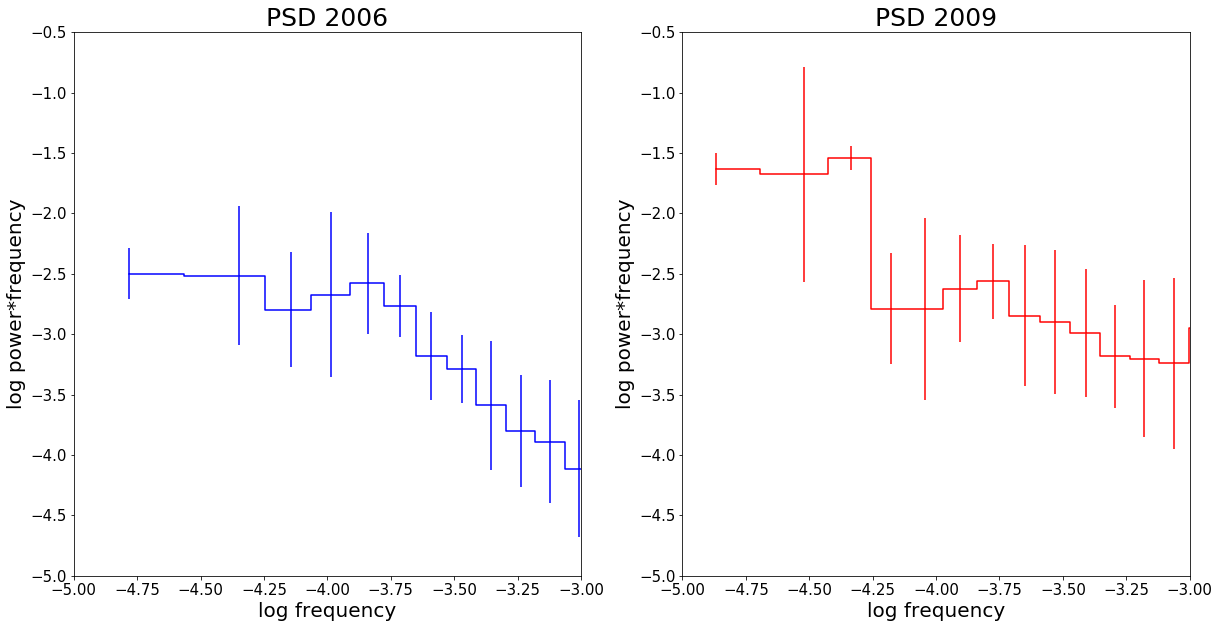

In [14]:
fig= plt.figure(figsize=(20,10))
ax5 = plt.subplot(121)
ax6 = plt.subplot(122)

ax5.step(F1_binned_06, p_times_f_data_b_06, where='mid',color="b")
ax6.step(F1_binned_09, p_times_f_data_b_09, where='mid', color="r")

ax5.errorbar(F1_binned_06, p_times_f_data_b_06, yerr=per_data_b_std_06, fmt=',',color="b", label='2006')
ax6.errorbar(F1_binned_09, p_times_f_data_b_09, yerr=per_data_b_std_09, fmt=',',color="r",label='2009')


ax5.set_xlabel("log frequency",fontsize=20)
ax5.set_ylabel("log power*frequency",fontsize=20)
ax5.set_xlim(-5.0,-3.0)
ax5.set_ylim(-5,-0.5)
ax5.tick_params(labelsize=15)
ax5.set_title("PSD 2006",fontsize=25)

ax6.set_xlabel("log frequency",fontsize=20)
ax6.set_ylabel("log power*frequency",fontsize=20)
ax6.set_xlim(-5.0,-3.0)
ax6.set_ylim(-5,-0.5)
ax6.tick_params(labelsize=15)
ax6.set_title("PSD 2009",fontsize=25)
plt.show()